# Detection et reconnaissance des couleurs des carrés
Dans ce notebook, nous présentons une technique de détection des carrées dans une image ainsi que l'extraction de la séquence de couleurs.

On commance par importer les bibliothèques nécessaires :

In [2]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

On charge l'image à traiter et on la met en RGB (opencv charge les images en BGR par défaut)

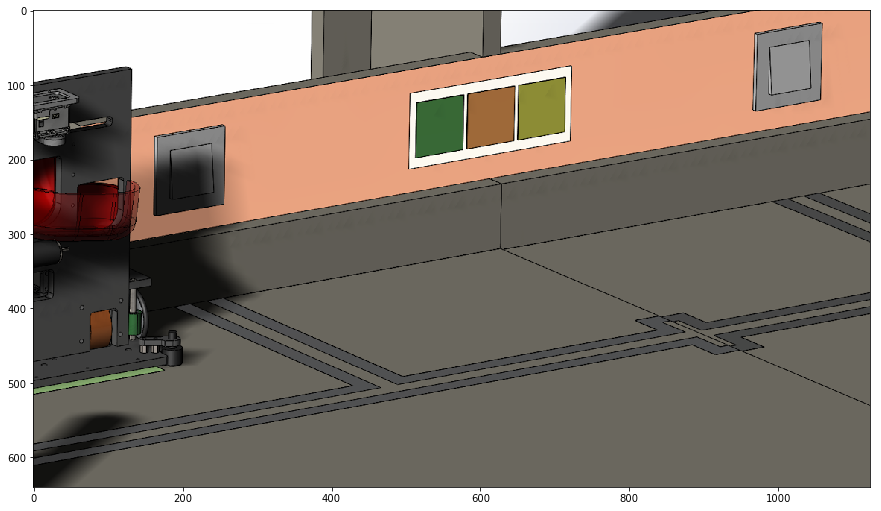

In [3]:
img_rw = cv2.imread("C:/Users/aloui_000/Documents/grebot/rectangles_extractor/Setup.png")
img = cv2.cvtColor(img_rw, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (15,15))
plt.imshow(img)

On transforme l'image en gris (pour faire la détection des contours)

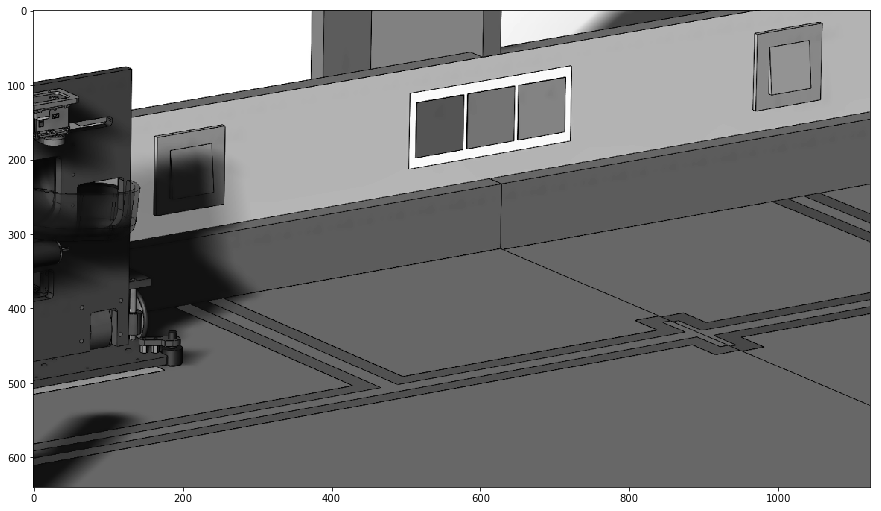

In [4]:
img_gray = cv2.cvtColor(img_rw, cv2.COLOR_BGR2GRAY)
img_gray = cv2.bilateralFilter(img_gray,9,11,11)
plt.figure(figsize = (15,15))
plt.imshow(img_gray, cmap='gray')

# Sobel

Avant de faire des choses plus complexes, un clin d'oeul à la méthode de Sobel qui permet de trouver les lignes dans une image tout en calculant l'angle d'incidance.

La technique utilise une simple convolution avec le noyau suivant :


| Noyau Vertical|
| --- |:-:| --: |
| -1  | 0 | 1   |
| -2  | 0 | 2   |
| -1  | 0 | 1   |

Ce noyau permet de détecter les lignes verticales. Ceci nous donne une image $G_x$

Ensuite, on fait la même chose avec le noyau 


| Noyau Horizontal|
| --- |:-: | --:   |
| -1  | -2 | -1   |
|  0  | 0  | 0     |
|  1  | 2  | 1     |

Ce noyau permet de détecter les lignes horizontales. Ceci nous donne une image $G_y$

Pour trouver l'amplitude du gradient on utilise la formule :
$G = \sqrt{G_x^2+G_y^2}$

Pour trouver l'angle d'incidence on utilise la formule :
$A = atan(G_x/G_y)$

Cette méthode est limitée, elle donne une image qui contient des valeurs négatifs, qui doivent par conséquence être décalés pour donner une valeur entre 0 et 255 ce qui donne une image de contour contenant du gris partout sauf au niveau des contours.

Elle est sensible au bruit (en effet le petit filtrage bilatéral servait à atténuer cet effet)

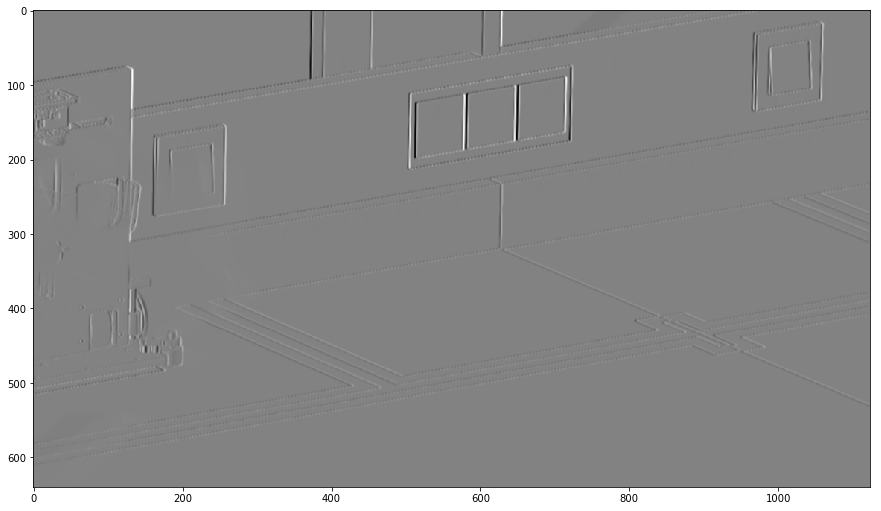

In [5]:
img_sobel = cv2.Sobel(img_gray,cv2.CV_64F,1,0,ksize=5)
plt.figure(figsize = (15,15))
plt.imshow(img_sobel, cmap='gray')

# Canny
Sobel est sympa, mais on peut faire mieux. En 1986, l'algo Canny (de john Canny) a été proposé et a réussi durant des années à rester parmis les algorithmes de détection de contour les plus efficaces.

Il s'agit d'une amélioration par rapport à Sobel.
Pour cel algo, on effectue donc du Sobel, mais par la suite, on utilise un seuillage afain de supprimer les artefacts et obtenir des lignes nets (une image noire avec des lignes blanches).

Deux seuils sont
On utilise deux seuils. ceci permet d'éliminer les contours qui ont de faible amplitudes, et garde les contours les plus prononcés ainsi que les contours sui leur sont connectés mais ayant une amplitude pas top.
U


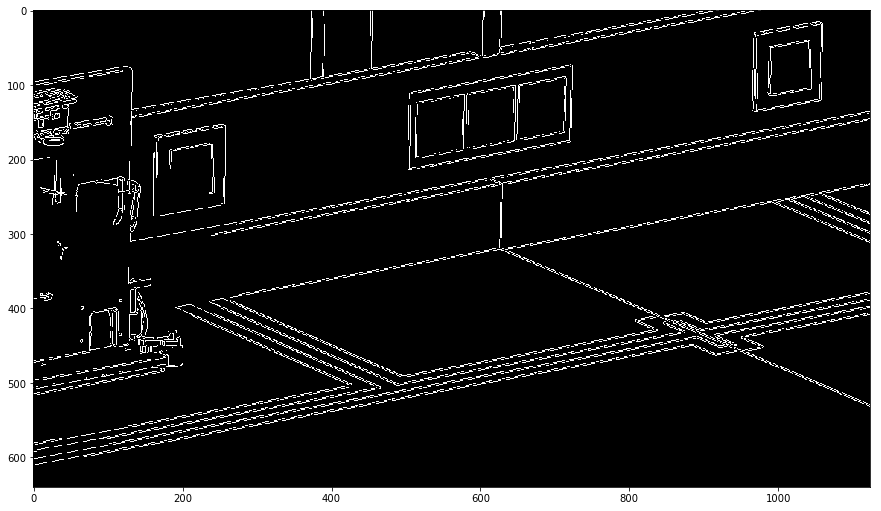

In [6]:
img_canny = cv2.Canny(img_gray, 100,200)
plt.figure(figsize = (15,15))
plt.imshow(img_canny, cmap='gray')

Il est temps d'extraire les contours à partir de l'image en réalisant une approximation sipple en chaine.

In [7]:
im2, contours, hierarchy = cv2.findContours(img_canny,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

On superpose les contours sur l'image

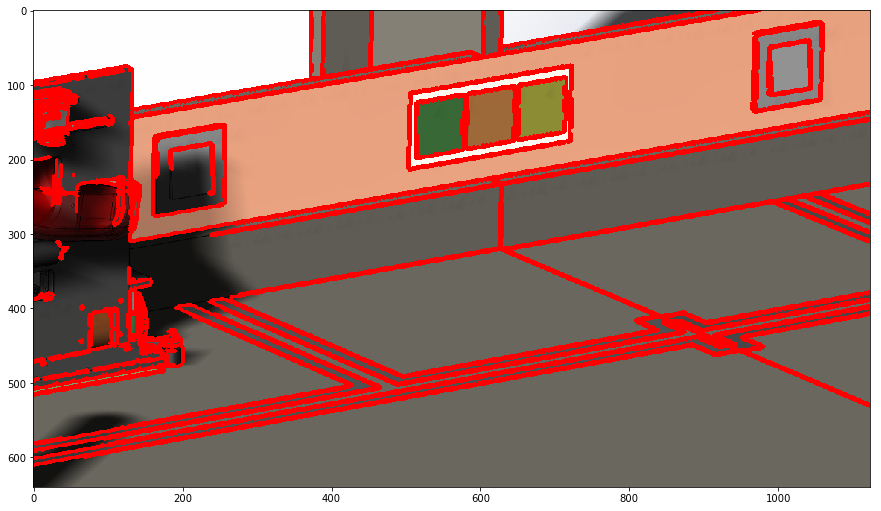

In [8]:
img_contoured=img.copy()
cv2.drawContours(img_contoured, contours, -1, (255,0,0), 3)
plt.figure(figsize = (15,15))
plt.imshow(img_contoured)

Bon, on voit qu'il ya trop de contours.
Faisons le tri :
- Que des contours pouvant etre approximés par 4 points (des rectangles quoi!)
- On ajoute aussi une condition sur la taille du rectangle.
- On calcule le contre de chaque rectangle.
- On reviens sur l'image d'origine qu'on convertie en hsv (plus simple si on veut classifier les couleurs par la suite)
- On affiche le cercle qui encadre chaque carré détecté
- On construit une liste des carrés

1 : rectangle found at [[546 155]] with center color[ 58 125 104] and mean color [[ 58 124 103]] and size 53

2 : rectangle found at [[614 143]] with center color[ 14 163 158] and mean color [[ 14 163 158]] and size 53

3 : rectangle found at [[682 131]] with center color[ 30 158 140] and mean color [[ 30 157 139]] and size 53

Detected 3 rectangles


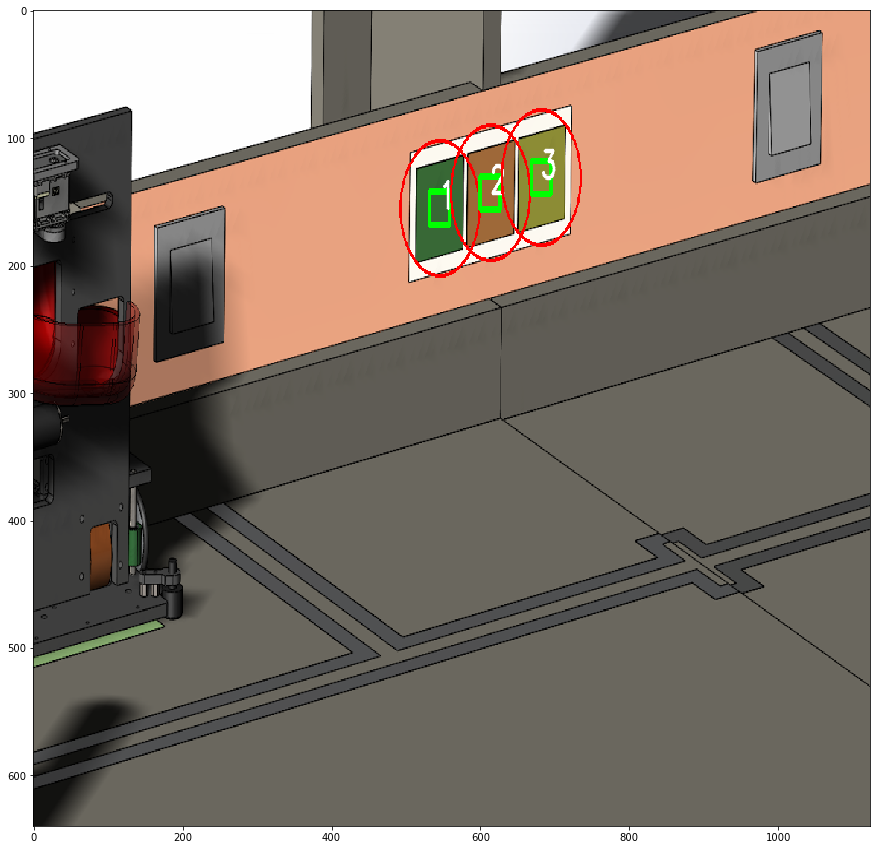

In [9]:
img_contoured_onlyrects=img.copy()
nb_detectedRects=0
# Short distance best configuration
min_radius = 45
max_radius = 60
# Long distance best configuration
# min_radius = 10
# max_radius = 20
# prepare lists of colors, radii and centers
centers=np.empty([0, 2])
radii = np.empty([0, 1])
colors=np.empty([0, 3])
# Now loop through all contours to select the best ones
for c in contours:
    #
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.04 * peri, True)
    if(len(approx)==4):
        (x,y),radius = cv2.minEnclosingCircle(approx)
        tcenter = (int(x),int(y))
        center = np.array([[int(x),int(y)]])
        radius = int(radius)
        # Detect only new rectagles
        if not(center in centers) and radius>min_radius and radius<max_radius:
            centers = np.append(centers, center,axis=0)
            radii = np.append(radii, np.reshape(radius,(1,1)),axis=0)

            nb_detectedRects = nb_detectedRects + 1
            
            img_hsv = cv2.cvtColor(img_rw, cv2.COLOR_BGR2HSV)
            # Extract color            
            securityDiv = 4
            startX = int(x-radius/securityDiv)
            endX = int(x+radius/securityDiv)
            startY = int(y-radius/securityDiv)
            endY = int(y+radius/securityDiv)
            
            cv2.rectangle(img_contoured_onlyrects,(startX,startY),(endX,endY),(0,255,0),3)
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(img_contoured_onlyrects,str(nb_detectedRects),(int(x),int(y)), font, 1,(255,255,255),2,cv2.LINE_AA)
            subImg=img_hsv[startY:endY, startX:endX,:]
            center_color = img_hsv[int(y), int(x)]
            color = np.average(np.average(subImg, axis= 0), axis= 0)
            color = np.reshape(color, (1,3)).astype(int)
            colors = np.append(colors, color,axis=0)
            # Extract hue
            hue=color[0]
            print("{} : rectangle found at {} with center color{} and mean color {} and size {}\n".format(nb_detectedRects, center,center_color, color, radius))
            cv2.circle(img_contoured_onlyrects,tcenter,radius,(255,0,0),2)
            #cv2.drawContours(img_contoured_onlyrects, approx, -1, (255,0,0), 3)

# Now we do have all needed data about 
# Let's sort our centers     
plt.figure(figsize = (15,15))
plt.imshow(img_contoured_onlyrects, interpolation='nearest', aspect='auto')
print("Detected {} rectangles".format(nb_detectedRects))

On définie une distance entre les couleurs en hsv

In [24]:
def hsv_dist(ref, color):
    dh = color[0]-ref[0]
    # ds = color[1]-ref[1]
    return np.sqrt(dh*dh)#+dv*dv)


On trie les couleurs de gauche à droite

In [16]:
indices = np.argsort(centers, axis=0) 
print(indices)

[[0 2]
 [1 1]
 [2 0]]


On définit la liste des couleurs de référence

In [37]:
# Black, Yellow, Green, Blue, Orange
# Convert hue from degrees to 255 base
# 0.71 = 255/360
ref=[[0,0,0],[54*0.71,0,0],[100*0.71,0,0],[210*0.71,0,0],[25*0.71,0,0]]
refNames =['Black','Yellow','Green','Blue','Orange']


On crée une fonction qui donne l'indice de la couleur dans la liste des références.

In [39]:
#find the color name
def findColorName(color):
    index = 0
    dist  = hsv_dist(ref[0], color)
    for i in range(1,np.shape(ref)[0]):
        newDist = hsv_dist(ref[i], color)
        if(newDist<dist):
            index = i
            dist = newDist
    return  index

On vérifie qu'on a bien détecté 3 carrés, et si oui, on extrait les indices des couleurs

In [40]:
if(np.shape(indices)[0]!=3):
    print("Error !!! more than one rect was found")
else :
    print("Found 3 colors")
    print(colors)
    for i in range(0,3):
        colorIndex = findColorName(colors[i,:])
        print("{} : {}".format(i, refNames[colorIndex]))
        

Found 3 colors
[[  58.  124.  103.]
 [  14.  163.  158.]
 [  30.  157.  139.]]
0 : Green
1 : Orange
2 : Yellow


Et voila!!

On a extrait nos rectangles ainsi que leurs couleurs respectifs en mode Texte
